# Internal Injection Analysis for Pedestal Stability Studies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [15]:
# === CONFIGURATION ===
data_dir = Path("/home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Data")
dac_values = [100, 200, 300, 400]
conditions = ["HV", "NoHV"]
fpga_to_pb = {209: "008", 210: "06"}

In [16]:
# channels to ignore
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}
ignore_channels = dead_channels | calibration_channels | notConnected_channels

In [17]:
# === FUNCTION TO READ AND PROCESS A FILE ===
def process_file(filepath):
    df = pd.read_csv(filepath)
    df = df[~df["Phase"].isin([4, 6, 7])]
    df = df[~df["Channel"].isin(ignore_channels)]
    return df.groupby("Channel")["ADC"].max().reset_index(name="ADC_max")

In [18]:
# === FUNCTION TO OBTAIN STATISTICS PER FPGA/DAC/HV ===
def aggregate_by_condition(fpga):
    pb = fpga_to_pb[fpga]
    results = []

    for dac in dac_values:
        for cond in conditions:
            folder = data_dir / f"{dac}_DAC_{cond}"
            pattern = rf"inj_adc_samples_{fpga}_pb{pb}_\d+_{dac}_(\d+)_{cond}.csv"
            
            all_runs = []
            for file in folder.glob("*.csv"):
                if re.search(pattern, file.name):
                    run_df = process_file(file)
                    run_df["Run"] = int(re.search(pattern, file.name).group(1))
                    all_runs.append(run_df)
            
            if not all_runs:
                print(f"No files for FPGA {fpga}, DAC {dac}, {cond}")
                continue

            merged = pd.concat(all_runs)
            stats = merged.groupby("Channel")["ADC_max"].agg(["mean", "std"]).reset_index()
            stats["FPGA"] = fpga
            stats["DAC"] = dac
            stats["Condition"] = cond
            results.append(stats)
    
    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

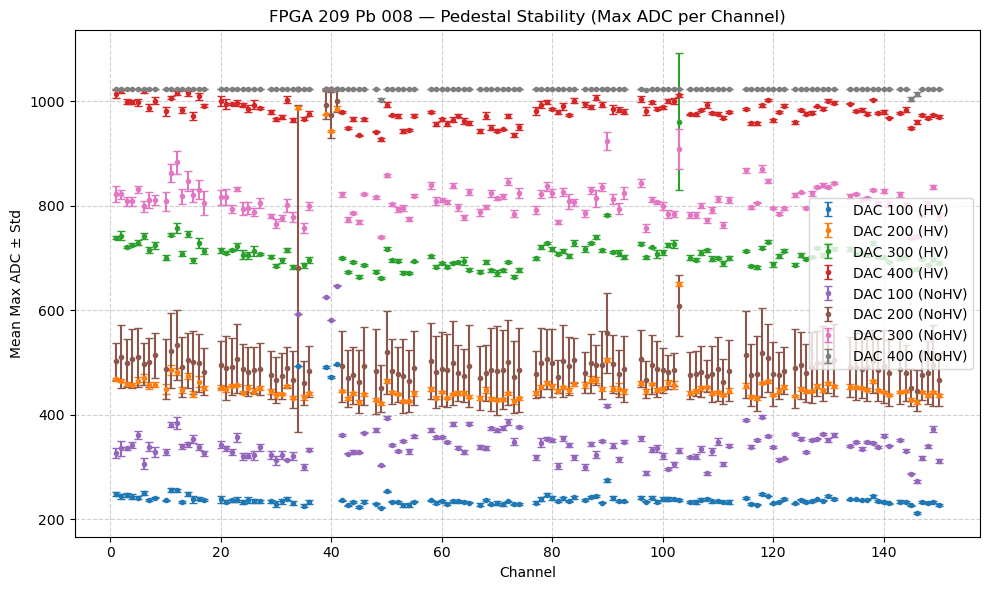

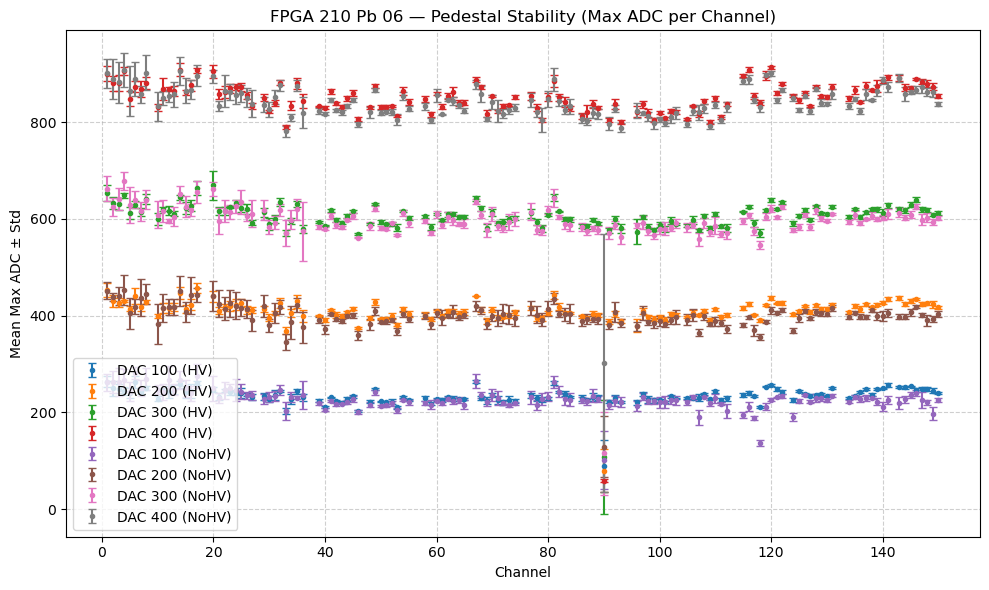

In [21]:
# === ANALYSE BOTH FPGAs ===
summary_all = pd.concat([aggregate_by_condition(fpga) for fpga in fpga_to_pb.keys()], ignore_index=True)

# === PLOT ===
def plot_fpga(summary, fpga):
    plt.figure(figsize=(10,6))
    subset = summary[summary["FPGA"] == fpga]
    
    for cond in conditions:
        for dac in dac_values:
            sel = subset[(subset["DAC"] == dac) & (subset["Condition"] == cond)]
            if sel.empty:
                continue
            plt.errorbar(
                sel["Channel"], sel["mean"], yerr=sel["std"],
                label=f"DAC {dac} ({cond})", fmt='.', capsize=3
            )

    plt.title(f"FPGA {fpga} Pb {fpga_to_pb[fpga]} — Pedestal Stability (Max ADC per Channel)")
    plt.xlabel("Channel")
    plt.ylabel("Mean Max ADC ± Std")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for fpga in fpga_to_pb.keys():
    plot_fpga(summary_all, fpga)